---
layout: notes
chapter: 3
chapter-title: Classification
permalink: /ml-book/chapter3/notes.html
---

## MNIST
* The MNIST dataset is a set of 70,000 small images of handwritten digits with labels
* This is probably the most used dataset for machine learning

In [3]:
from sklearn.datasets import fetch_openml
import numpy as np
# MNIST changed to https://www.openml.org/d/554
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
# Do this to follow along with Geron
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


5

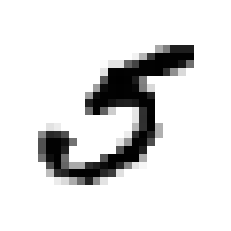

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

dim = 28
some_num = 36_000
example = X[some_num]
plt.imshow(example.reshape((dim, dim)), cmap="binary")
plt.axis("off");
y[some_num]

### Split into train / test!

In [6]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [7]:
# Shuffling
shuf_order = np.random.permutation(len(y_train))
X_train, y_train = X_train[shuf_order, :], y_train[shuf_order]

## Training a Binary Classifier

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

In [10]:
sgd_clf.predict([example])
# This is sometimes False

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9652 , 0.95535, 0.95545])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
n5c = Never5Classifier()
n5c.fit(X_train, y_train_5)
cross_val_score(n5c, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9068 , 0.91315, 0.909  ])

### Misleading Performance Conclusions
* Results for our Stochastic Gradient Descent Classifier are ~95%!
* These results are ostensibly good, because only guessing False would be 90% accurate
* Thus, accuracy is not the preferred performance measure for classifiers, especially when data is skewed

### Confusion Matrix
* General idea is the count the number of times class A was classified as class B

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# This is a pretty useful function, what it does is
# Does the k-fold CV and notes the prediction in each fold (using the other
# as training data), then it stacks them all at the end

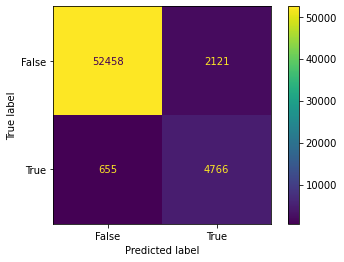

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Requires sklearn > 0.24
cmd = ConfusionMatrixDisplay.from_predictions(y_train_5, y_train_pred)
cm = cmd.confusion_matrix

This is a useful image for understanding this straight from Geron's book:

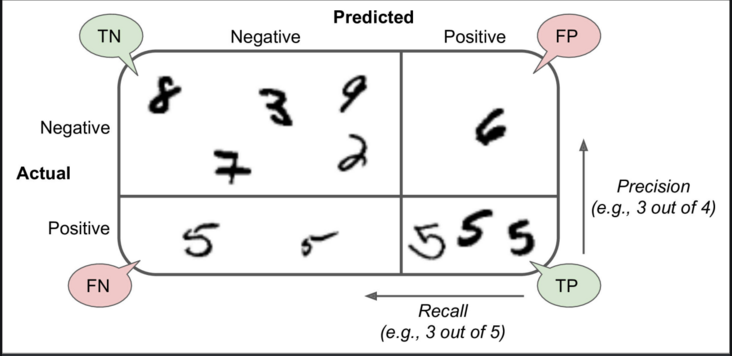

### Precision, Recall, and F1 Score

#### Precision

$ precision = \frac {TP}{TP + FP} $

> When your classifier claims to predict a 5, it is correct _precision_ % of the time.


#### Recall

$ recall = \frac {TP}{TP + FN} $

> It only detects _recall_ % of the 5's.

#### $F_1$ Score

$ F_1 = \frac {2}{\frac{1}{precision} + \frac{1}{recall}} = \frac {TP}{TP + \frac{FN + TP}{2}} $

> Harmonic mean of recall and precision. Both need to be high to get a high $F_1$ Score.

#### Precision/Recall Scenarios

* Scenario 1: Safe video classifier, if video is safe --> 1, else 0. We want high precision because we never want the model thinking that the video is safe, when in reality it is violent. And we don't care if we block a decent amount of safe videos.
* Scenario 2: Detect shoplifters on security footage, if shoplifting --> 1, else 0. We want high recall because we never want the model thinking that the person is not shoplifting, when in reality they are. And we don't care if we occasionally accuse people of shoplifting that actually aren't.

* Scenario 3: Taking a bet model, if you should bet --> 1, else 0. We want high precision because we never want to have the model predict a win, but the bet is actually a loss. Even at the price of missing out on a few good opportunities.
* Scenario 4: Will jumping off this structure kill me, if yes --> 1, else 0. We want high recall because we never want to predict that it won't kill me, but in reality it would. Sorry for the grim example...

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train_5, y_train_pred)) # 4766 / (4766 + 2121)
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.6920284594162915
0.8791735842095554
0.7744556386090348
